In [1]:
import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from ema_workbench import load_results, ScalarOutcome

from problem_formulation import get_model_for_problem_formulation

### Scenarios

In [2]:
scenarios = pd.read_csv(os.path.join('experiment', 'scenario_cart.csv')).rename(columns={'Unnamed: 0': 'uncertainties'}).set_index('uncertainties')

In [3]:
scenarios

,box_1_max,box_2_max,box_3_max
uncertainties,,,
A.3_pfail,0.075871,0.143766,0.99818


### Policies

In [5]:
policies = pd.DataFrame()
for box in range(1, 6):
    policy = pd.read_csv(f'mordm/reference_set_scenario_{box}.csv')
    selected_policy = policy.sort_values(by=['z_Az3_Expected_Number_of_Deaths', 
                                                                  'z_Expected_Number_of_Deaths',
                                                                  'z_Az3_Expected_Annual_Damage',
                                                                  'z_Evacuation_Costs',
                                                                  'z_Dike_Investment_Costs',
                                                                  'z_RfR_Investment_Costs']).iloc[:3]
    selected_policy['box'] = box
    policies = pd.concat([policies, selected_policy], ignore_index=True)
    

In [6]:
policies2evaluate = policies.sort_values(by=['z_Az3_Expected_Number_of_Deaths',
                                             'z_Expected_Number_of_Deaths',
                                             'z_Az3_Expected_Annual_Damage',
                                             'z_Evacuation_Costs',
                                             'z_Dike_Investment_Costs',
                                             'z_RfR_Investment_Costs']).iloc[[0, 1, 3]]

In [7]:
policies2evaluate.to_csv('mordm/policies2evaluate.csv',index=False)

In [8]:
pd.read_csv('mordm/policies2evaluate.csv')

,z_0_RfR_0,z_0_RfR_1,z_0_RfR_2,z_1_RfR_0,z_1_RfR_1,z_1_RfR_2,z_2_RfR_0,z_2_RfR_1,z_2_RfR_2,z_3_RfR_0,...,z_Az5_DikeIncrease_0,z_Az5_DikeIncrease_1,z_Az5_DikeIncrease_2,z_Dike_Investment_Costs,z_Evacuation_Costs,z_RfR_Investment_Costs,z_Expected_Number_of_Deaths,z_Az3_Expected_Annual_Damage,z_Az3_Expected_Number_of_Deaths,box
0,0,0,0,0,0,0,1,1,1,1,...,0,0,0,22167818.0,291.729334,334500000.0,0.001956,0.0,0.0,4
1,0,0,1,0,0,0,1,1,0,0,...,0,0,0,26403379.0,825.781835,388400000.0,0.002301,0.0,0.0,1
2,0,0,0,0,0,0,1,1,1,1,...,0,0,0,22167818.0,0.000000,455700000.0,0.003021,0.0,0.0,3


### Analysis

In [9]:
problem_formulation_id = 8
dike_model, planning_step = get_model_for_problem_formulation(problem_formulation_id)

uncertainties = [u.name for u in dike_model.uncertainties]
levers = [l.name for l in dike_model.levers]
ooi = [o.name for o in dike_model.outcomes]
ooi_dr3 = ['A.3_Expected Annual Damage', 'A.3_Expected Number of Deaths', 'Expected Number of Deaths', 'Evacuation Costs']

In [10]:
experiments, outcomes = load_results('mordm/results_policies2evaluate.tar.gz')
df_outcomes = pd.DataFrame(outcomes)

In [11]:
df_outcomes.describe()

,Dike Investment Costs,Evacuation Costs,RfR Investment Costs,Expected Number of Deaths,A.3_Expected Annual Damage,A.3_Expected Number of Deaths
count,3.000000e+03,3000.000000,3.000000e+03,3000.000000,3.000000e+03,3000.000000
mean,2.357967e+07,8003.272933,3.928667e+08,0.393828,8.711055e+06,0.008028
std,1.996996e+06,11536.717518,4.958866e+07,0.603140,8.545493e+07,0.097975
min,2.216782e+07,0.000000,3.345000e+08,0.000000,0.000000e+00,0.000000
25%,2.216782e+07,0.000000,3.345000e+08,0.019370,0.000000e+00,0.000000
50%,2.216782e+07,3012.579902,3.884000e+08,0.089247,0.000000e+00,0.000000
75%,2.640338e+07,13486.796700,4.557000e+08,0.659661,0.000000e+00,0.000000
max,2.640338e+07,130287.864347,4.557000e+08,4.910930,1.578296e+09,3.005924


In [12]:
def s_to_n(data, direction):
    mean = np.mean(data)
    std = np.std(data)
    
    if direction==ScalarOutcome.MINIMIZE:
        return mean/std
    else:
        return mean*std

In [13]:
overall_scores = {}
for policy in np.unique(experiments['policy']):
    scores = {}
    
    logical = experiments['policy']==policy
    
    for outcome in dike_model.outcomes:
        if outcome.name in ooi_dr3:
            value  = outcomes[outcome.name][logical]
            sn_ratio = s_to_n(value, outcome.kind)
            scores[outcome.name] = sn_ratio
    overall_scores[policy] = scores
scores = pd.DataFrame.from_dict(overall_scores).T
scores

/var/folders/3q/jhjx81s17k57kntt8djynfgc0000gn/T/ipykernel_25527/2665571092.py:6: RuntimeWarning: invalid value encountered in scalar divide
  return mean/std


,Evacuation Costs,Expected Number of Deaths,A.3_Expected Annual Damage,A.3_Expected Number of Deaths
0,1.253804,1.037032,0.110365,0.107026
1,0.953380,0.704172,0.096741,0.096084
2,NaN,1.001042,0.099624,0.098315


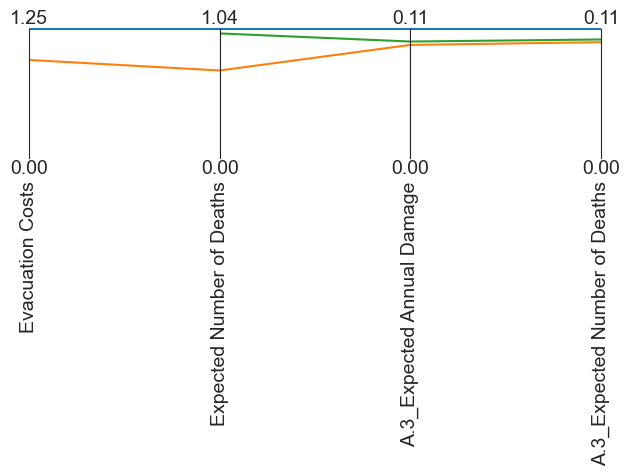

In [14]:
from ema_workbench.analysis import parcoords

data = scores
limits = parcoords.get_limits(data)
limits.loc[0, ooi_dr3] = 0

paraxes = parcoords.ParallelAxes(limits)
paraxes.plot(data)
plt.show()

In [15]:
def calculate_regret(data, best):
    return np.abs(best-data)

In [16]:
overall_regret = {}
max_regret = {}
for outcome in dike_model.outcomes:
    policy_column = experiments['policy']
    
    # create a DataFrame with all the relevent information
    # i.e., policy, scenario_id, and scores
    data = pd.DataFrame({outcome.name: outcomes[outcome.name], 
                         "policy":experiments['policy'],
                         "scenario":experiments['scenario']})
    
    # reorient the data by indexing with policy and scenario id
    data = data.pivot(index='scenario', columns='policy')
    
    # flatten the resulting hierarchical index resulting from 
    # pivoting, (might be a nicer solution possible)
    data.columns = data.columns.get_level_values(1)
    
    # we need to control the broadcasting. 
    # max returns a 1d vector across scenario id. By passing
    # np.newaxis we ensure that the shape is the same as the data
    # next we take the absolute value
    #
    # basically we take the difference of the maximum across 
    # the row and the actual values in the row
    #
    outcome_regret = (data.max(axis=1).values[:, np.newaxis] - data).abs()
    
    overall_regret[outcome.name] = outcome_regret
    max_regret[outcome.name] = outcome_regret.max()

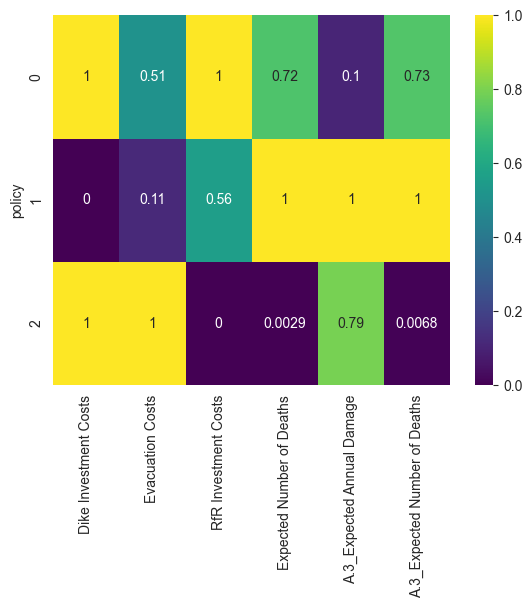

In [17]:
max_regret = pd.DataFrame(max_regret)
sns.heatmap(max_regret/max_regret.max(), cmap='viridis', annot=True)
plt.show()

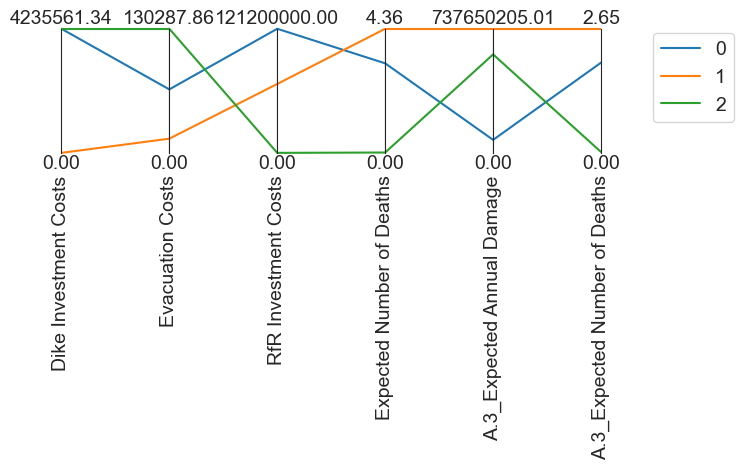

In [18]:
colors = sns.color_palette()

data = max_regret

# makes it easier to identify the policy associated with each line
# in the parcoords plot
# data['policy'] = data.index.astype("float64")

limits = parcoords.get_limits(data)
limits.loc[0, ooi_dr3] = 0

paraxes = parcoords.ParallelAxes(limits)
for i, (index, row) in enumerate(data.iterrows()):
    paraxes.plot(row.to_frame().T, label=str(index), color=colors[i])
paraxes.legend()
    
plt.show()

In [19]:
from collections import defaultdict

policy_regret = defaultdict(dict)
for key, value in overall_regret.items():
    for policy in value:
        policy_regret[policy][key] = value[policy]

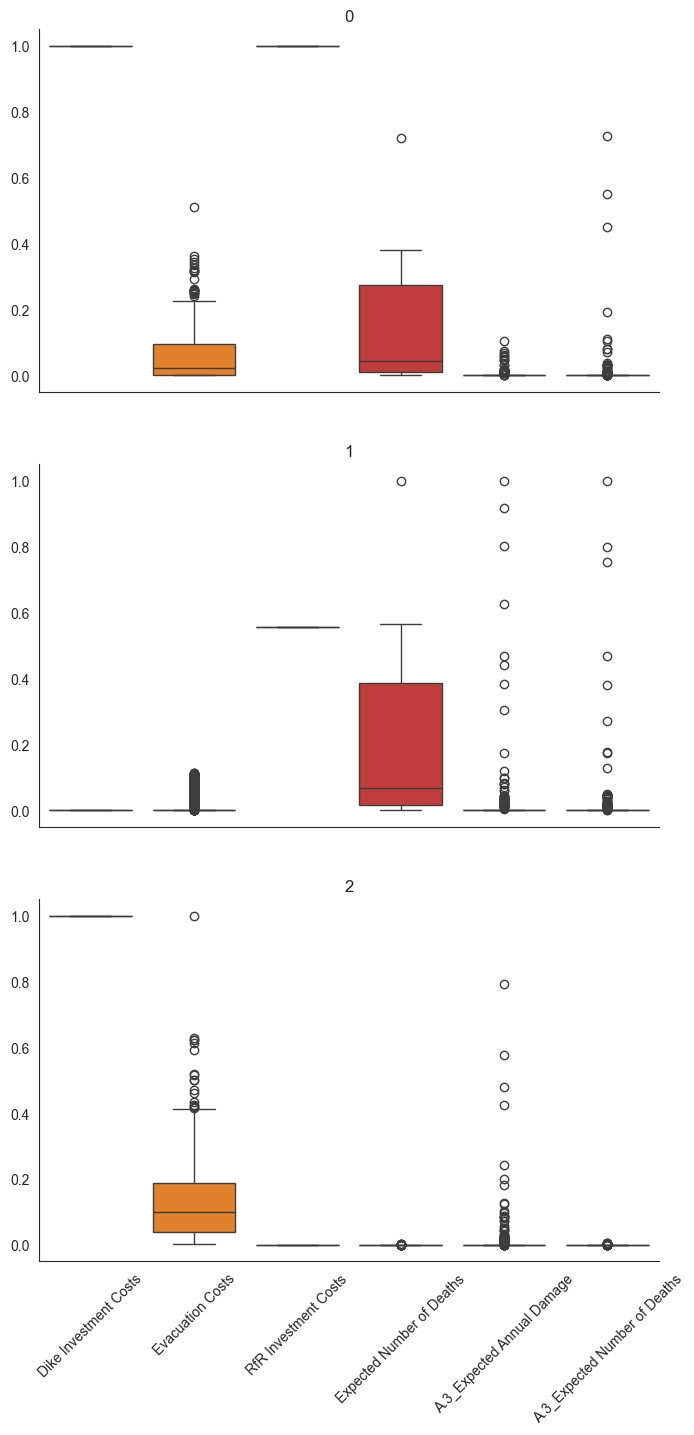

In [20]:
# this generates a 2 plots with a shared y and x axis
fig, axes = plt.subplots(nrows=3, figsize=(8,16), 
                         sharey=True, sharex=True)

# to ensure easy iteration over the axes grid, we turn it
# into a list. Because there are four plots, I hard coded
# this. 


# zip allows us to zip together the list of axes and the list of 
# key value pairs return by items. If we iterate over this
# it returns a tuple of length 2. The first item is the ax
# the second items is the key value pair.
for ax, (policy, regret) in zip(axes, policy_regret.items()):
    data = pd.DataFrame(regret)

    # we need to scale the regret to ensure fair visual
    # comparison. We can do that by divding by the maximum regret
    data = data/max_regret.max(axis=0)
    sns.boxplot(data=data, ax=ax)
    
    # removes top and left hand black outline of axes
    sns.despine()
    
    # ensure we know which policy the figure is for
    ax.set_title(str(policy))
    
plt.setp(ax.get_xticklabels(), rotation=45)
plt.show()

In [21]:
from ema_workbench.analysis import prim

x = experiments[uncertainties]
y = outcomes['Expected Number of Deaths'] < 0.5
# 
prim_alg = prim.Prim(x, y, threshold=0.5)
box = prim_alg.find_box()

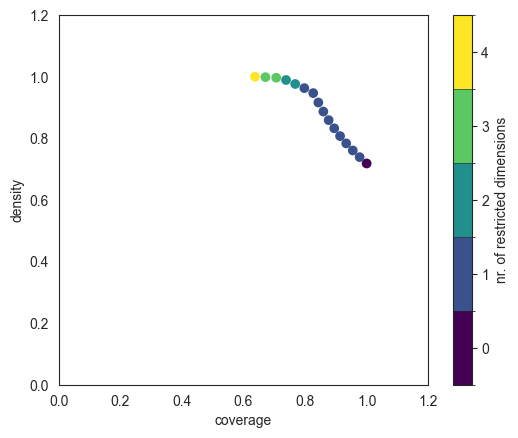

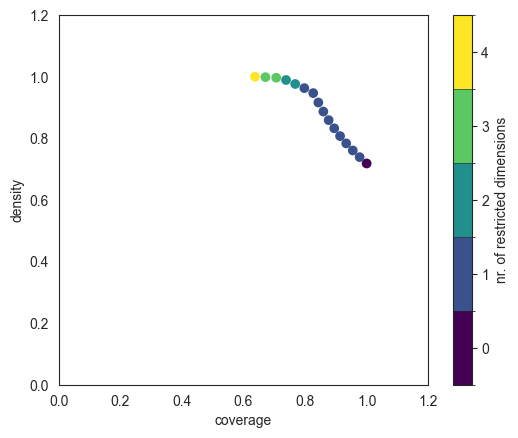

In [22]:
box.show_tradeoff()

In [23]:
box.inspect(1)

coverage       0.977262
density        0.738947
id             1.000000
k           2106.000000
mass           0.950000
mean           0.738947
n           2850.000000
res_dim        1.000000
Name: 1, dtype: float64

             box 1                             
               min       max  qp value qp value
A.1_pfail  0.05007  0.999865  0.007319      NaN


[None]